<a href="https://colab.research.google.com/github/fedrianMF/Robot-Trading/blob/main/Challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. CONFIGURACION DE AMBIENTE

###1.1. Declaracion de Variables Globales

In [1]:
df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, decision_felix = [], 0.0, '', 0.0, '', ''

###1.2. Verificacion de Librerias

In [2]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'
print('------')
!pip show yfinance | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1
------
Name: yfinance
Version: 0.2.18


#2. OBTENCION DE DATOS

###2.1. Importamos librerias necesarias

In [3]:
import yfinance as yf
import requests
import time
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from datetime import datetime
from IPython.display import clear_output

###2.2. Crear funcion importar_base_bitcoin

In [4]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  ticker = "BTC-USD"
  stock = yf.Ticker(ticker)
  df_bitcoin = stock.history(period="7d", interval="1m")

importar_base_bitcoin()
df_bitcoin

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-16 19:26:00+00:00,27052.705078,27052.705078,27052.705078,27052.705078,0,0.0,0.0
2023-05-16 19:28:00+00:00,27046.443359,27046.443359,27046.443359,27046.443359,0,0.0,0.0
2023-05-16 19:29:00+00:00,27041.470703,27041.470703,27041.470703,27041.470703,0,0.0,0.0
2023-05-16 19:30:00+00:00,27037.251953,27037.251953,27037.251953,27037.251953,0,0.0,0.0
2023-05-16 19:31:00+00:00,27040.283203,27040.283203,27040.283203,27040.283203,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-22 00:49:00+00:00,26645.386719,26645.386719,26645.386719,26645.386719,28116992,0.0,0.0
2023-05-22 00:50:00+00:00,26654.769531,26654.769531,26654.769531,26654.769531,0,0.0,0.0
2023-05-22 00:51:00+00:00,26652.796875,26652.796875,26652.796875,26652.796875,0,0.0,0.0


|11 112q  ###2.3. Crear funcion extraer_tendencias

In [5]:
def extraer_tendencias():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36 Edg/113.0.1774.42'}
  url = 'https://coinmarketcap.com/'
  response = requests.get(url, headers = headers)
  soup = BeautifulSoup(response.content, 'html.parser')
  bitcoin_row = soup.find('table').tbody.tr
  precio_actual = float(bitcoin_row.findAll('td')[3].find('span').getText().replace(',','').replace('$',''))
  tendencia = 'Baja' if 'icon-Caret-down' in bitcoin_row.findAll('td')[4].find('span').span.get('class') else 'Baja'
  tendencia_local = bitcoin_row.findAll('td')[4].find('span').getText().replace('%','')
  #print(tendencia_local)

extraer_tendencias()
print(str(precio_actual), tendencia)

26662.8 Baja


#3. LIMPIEZA DE DATOS

###3.1. Crear funcion limpieza_datos

In [6]:
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin_limpio = df_bitcoin.copy()
  #indices unicos
  indices_duplicados = df_bitcoin_limpio.index.duplicated()
  df_bitcoin_limpio = df_bitcoin_limpio[~indices_duplicados]
  #convertir valores nulos 'Close' en 0
  df_bitcoin_limpio['Close'].fillna(0, inplace=True)
  #'Volume' mayor a 0
  if not (df_bitcoin_limpio['Volume'] > 0).all():
      df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]
  #Grafico boxplot
  #plt.figure(figsize=(8, 6))
  #plt.boxplot(df_bitcoin_limpio["Close"])
  #plt.title("Boxplot del precio close del Bitcoin")
  #plt.ylabel("Precio")
  #plt.show()
  #Identificar los outliers
  q1 = df_bitcoin_limpio['Close'].quantile(0.25)
  q3 = df_bitcoin_limpio['Close'].quantile(0.75)
  iqr = q3 - q1
  outliers = df_bitcoin_limpio[
      (df_bitcoin_limpio['Close'] < (q1 - 1.5 * iqr)) |
       (df_bitcoin_limpio['Close'] > (q3 + 1.5 * iqr))]
  # Eliminar los outliers de 'Close'
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.isin(outliers)].dropna()
  #Filtro 'close' entre q1 y q3
  df_bitcoin_limpio = df_bitcoin_limpio[
      (df_bitcoin_limpio['Close'] >= q1) & 
       (df_bitcoin_limpio['Close'] <= q3)]
  #Calculo prmdio 'Close'
  media_bitcoin = df_bitcoin_limpio['Close'].mean()

limpieza_datos()
media_bitcoin

26981.77595703125

#4. TOMAR DECISIONES

###4.1. Crear funcion tomar_decisiones

In [7]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision 
  if (precio_actual >= media_bitcoin) and (tendencia == 'Baja'):
    algoritmo_decision = 'Vender'
  elif (precio_actual < media_bitcoin) and (tendencia == 'Alta'):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Sin comentarios'

def tomar_decisiones_felix():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  decision_felix 
  if precio_actual < media_bitcoin and tendencia == "Alta":
    if precio_actual < df_bitcoin['Close'].min():
        decision_felix = "comprar con urgencia"
    else:
        decision = "comprar"
  elif precio_actual > media_bitcoin and tendencia == "Baja":
      if precio_actual > df_bitcoin['Close'].max():
          decision_felix = "vender con urgencia"
      else:
          decision_felix = "evitar"
  else:
      decision_felix = "mantener"

tomar_decisiones()
tomar_decisiones_felix()
print(algoritmo_decision, decision_felix)

Sin comentarios mantener


#5. VISUALIZACION

###5.1. crear funcion visualizacion

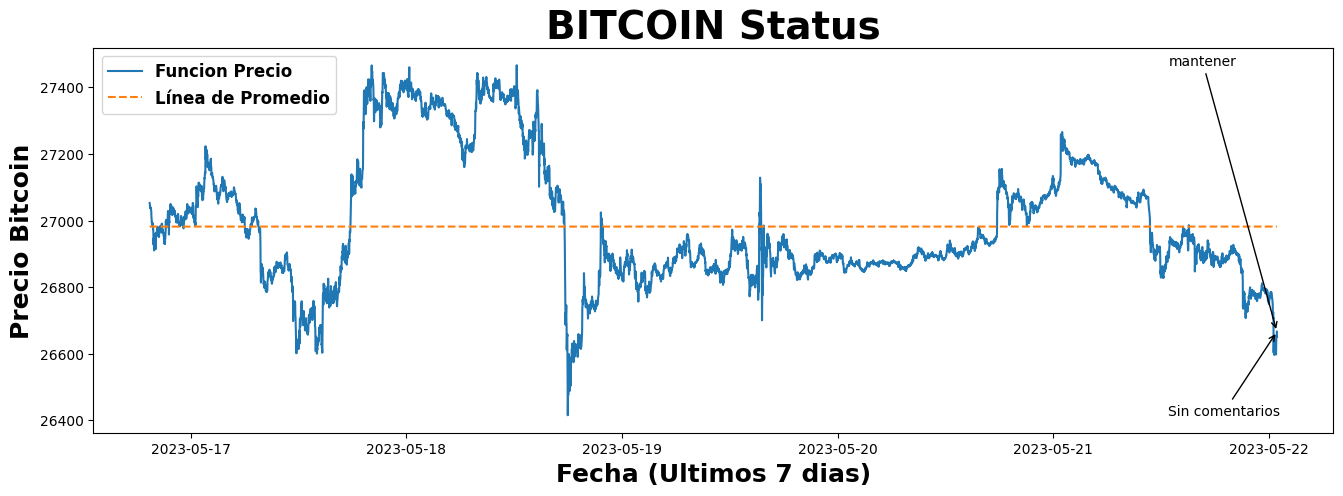

In [8]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision 
  df_bitcoin['Promedio'] = media_bitcoin #Adicionar columna Promedio
  fig = plt.figure(figsize=(16, 5)) #Tamaño grafico
  ax = fig.add_subplot(1, 1, 1) 
  ax.set_title("BITCOIN Status", fontsize=28, fontweight='bold') #Titulo Grafico
  ax.set_xlabel('Fecha (Ultimos 7 dias)', fontsize=18, fontweight='bold')
  ax.set_ylabel('Precio Bitcoin', fontsize=18, fontweight='bold')
  ax.plot(df_bitcoin.index, 
          df_bitcoin["Close"], 
          label='Funcion Precio') # Funcion de Close
  ax.plot(df_bitcoin.index, 
          df_bitcoin["Promedio"], 
          linestyle='--', 
          label='Línea de Promedio') # Funcion de Promedio
  ax.legend(loc='upper left', prop={'size': 12, 'weight': 'bold'})
  plt.annotate(algoritmo_decision, 
               xy=(df_bitcoin.index[-1], df_bitcoin["Close"][-1]), 
               xytext=(df_bitcoin.index[-720], df_bitcoin["Close"].min()),
               arrowprops=dict(facecolor='black', arrowstyle='->')) #Mostrar Mensaje
  plt.annotate(decision_felix, 
               xy=(df_bitcoin.index[-1], df_bitcoin["Close"][-1]), 
               xytext=(df_bitcoin.index[-720], df_bitcoin["Close"].max()),
               arrowprops=dict(facecolor='black', arrowstyle='->')) #Mostrar Mensaje Felix
  plt.show()# Mostrar el gráfico

visualizacion()

#6. AUTOMATIZACION

###6.1. Loop

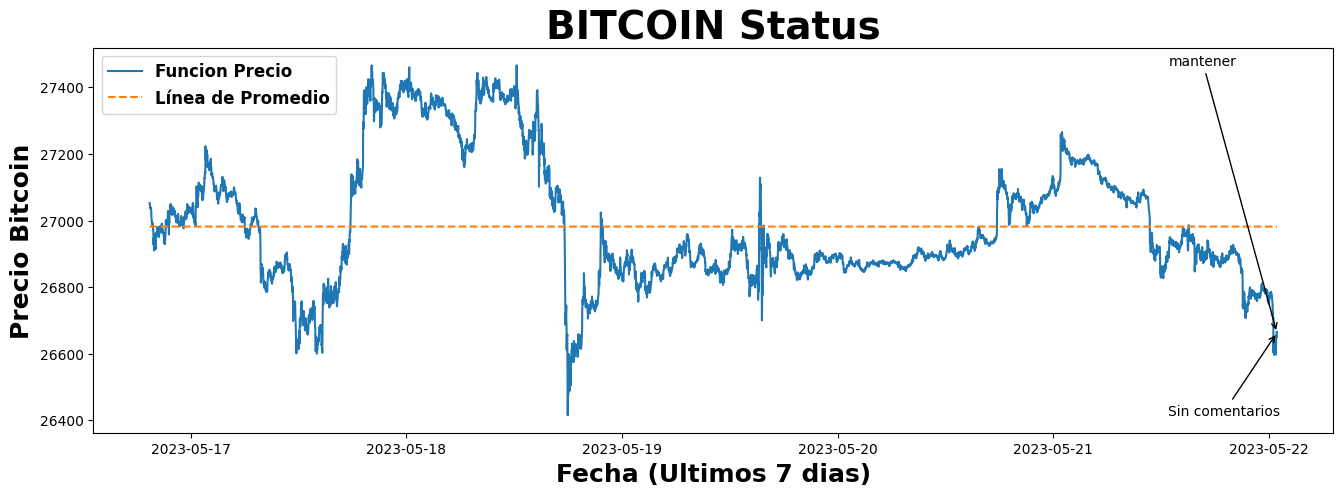

In [ ]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(10)